# <span style="color:red">**Project ID: RDP-2025-001  Retinopathy Detection**</span>

### Team ID: ***PTID-AI-APR-25-1112***

## **Business Case**

➤Retinopathy can cause vision loss or blindness if not detected early.

➤Manual diagnosis is slow, subjective, and requires expert ophthalmologists.

➤Inconsistent results due to human interpretation.

➤An automated deep learning model can provide fast, accurate, and consistent diagnosis.

➤Reduced workload for healthcare professionals.

➤Scalable solution for hospitals, diagnostic centers, and telemedicine.

## ***Project Description***
Using a labeled dataset of retinal images with three categories:

➤mild

➤moderate

➤severe retinopathy

Develop an automated deep learning model for retinopathy detection from retinal images

➤Implement image preprocessing techniques (resizing, normalization, augmentation).

➤Design and train a convolutional neural network (CNN) for image classification.

➤Optimize the model for high accuracy, precision, and recall.

➤Evaluate the model using metrics such as accuracy, F1-score, and confusion matrix.

➤Deploy the model as a scalable solution for hospitals and diagnostic centers.

## Basic Libraries

In [2]:
# General Purpose Libraries
import os
import random
import warnings
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Ignore Warnings
warnings.filterwarnings('ignore')


# Scikit-learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# TensorFlow & Keras Core
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Flatten, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Pretrained CNN Architectures
from tensorflow.keras.applications import (
    MobileNetV2, DenseNet121, ResNet50V2,DenseNet201
)



## Importing the Data

In [3]:
# Defining dataset path
data_dir = "/content/drive/MyDrive/data/retinopathy"

In [4]:
files=os.listdir(data_dir)
print(files)

['data_all.csv', 'images', 'split_data']


In [5]:
images =os.path.join(data_dir,'images')
num_images = len(os.listdir(images))
print(f"Total images: {num_images}")

Total images: 1764


#### ***Insights***
There are totally 1764 images

In [6]:
data_csv = os.path.join(data_dir,'data_all.csv')
data = pd.read_csv(data_csv)
data.head()

,Unnamed: 0,file,cat
0,0,o_c1t10003118.jpg,1
1,1,o_c1t1003016260.jpg,1
2,2,o_c1t1004522299.jpg,1
3,3,o_c1t1008823172.jpg,1
4,4,o_c1t1011431188.jpg,1


#### ***Insights***
There are file names with their category of retinopathy in this dataset

In [7]:
data.drop(columns='Unnamed: 0',inplace=True)

In [8]:
data.cat.unique()

array([1, 2, 3])

#### ***Insights***
➤ we could see the three stages of retinopathy here


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    1764 non-null   object
 1   cat     1764 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.7+ KB


## Visualising the images

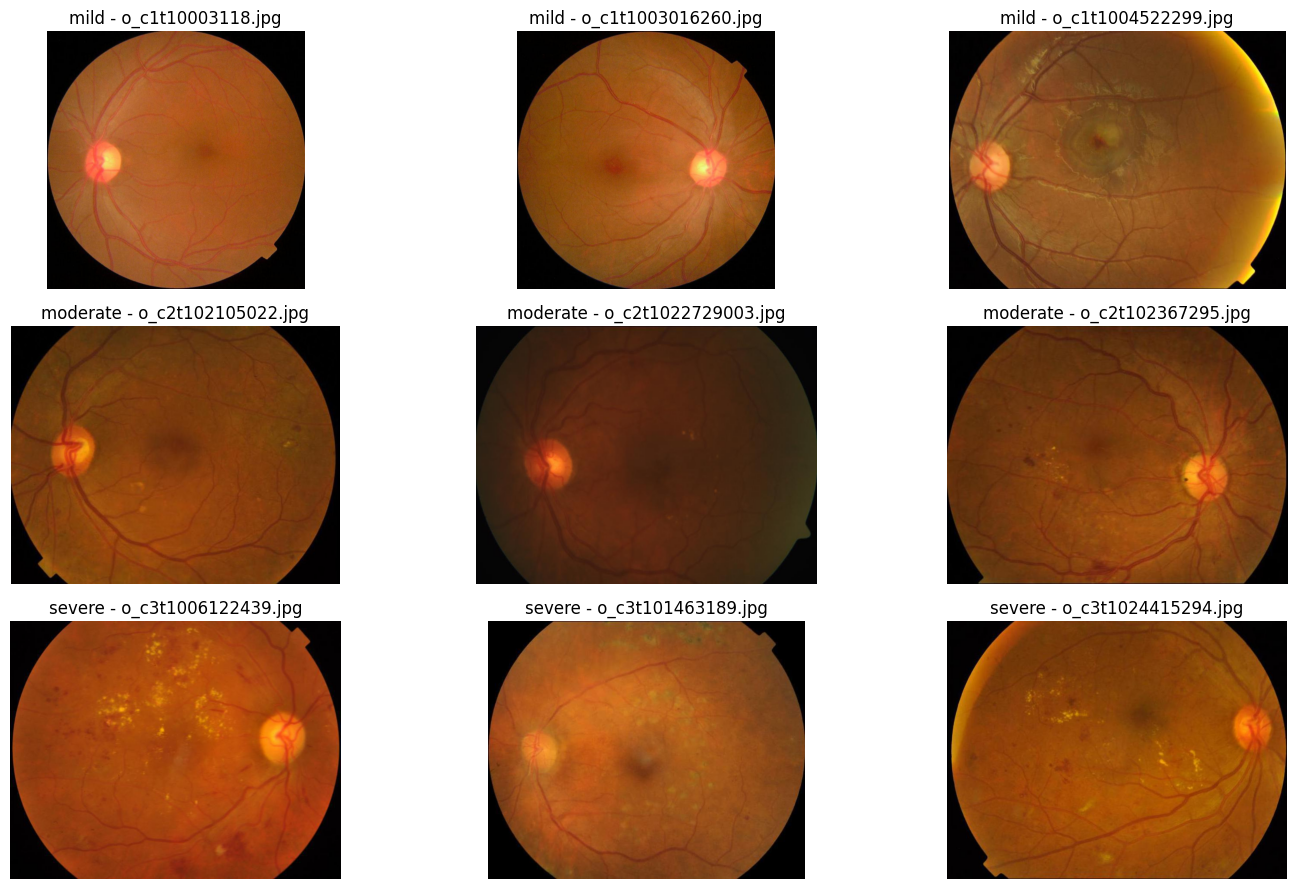

In [10]:
# Map class numbers to labels
label_map = {1: 'mild', 2: 'moderate', 3: 'severe'}
data['label'] = data['cat'].map(label_map)

categories = ['mild', 'moderate', 'severe']
plt.figure(figsize=(15, 9))


for idx, category in enumerate(categories):
    samples = data[data['label'] == category].head(3)

    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(images, row['file'])

        try:
            img = Image.open(img_path)
            plt.subplot(len(categories), 3, idx * 3 + i + 1)
            plt.imshow(img)
            plt.title(f"{category} - {row['file']}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()


## Basic checks on images

Number of images in each category:
Mild Retinopathy (c1): 811
Moderate Retinopathy (c2): 569
Severe Retinopathy (c3): 384


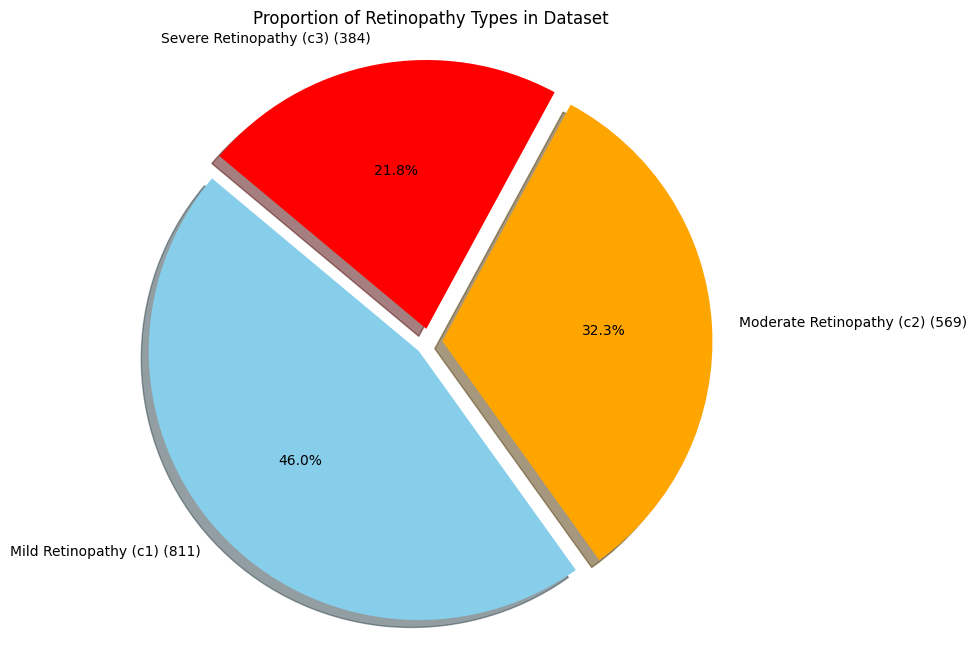

In [11]:
category_labels = {
    1: 'Mild Retinopathy (c1)',
    2: 'Moderate Retinopathy (c2)',
    3: 'Severe Retinopathy (c3)'
}

data['label'] = data['cat'].map(category_labels)

category_counts = data['label'].value_counts()
print("Number of images in each category:")
for label, count in category_counts.items():
    print(f"{label}: {count}")

# Plotting the pie chart
plt.figure(figsize=(8, 8))
colors = ['skyblue', 'orange', 'red']
explode = [0.05] * len(category_counts)
plt.pie(
    category_counts.values,
    labels=[f"{label} ({count})" for label, count in category_counts.items()],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)

plt.title('Proportion of Retinopathy Types in Dataset')
plt.axis('equal')
plt.show()

#### ***Insights***
We could see the slight imbalance in this dataset as there are only 21.8% images of severe Retinopathy

In [12]:
from tqdm import tqdm


stats_per_class = {}

for cat_num, cat_name in label_map.items():
    subset = data[data['cat'] == cat_num]

    heights, widths = [], []
    means, stds, mins, maxs = [], [], [], []

    print(f"\nProcessing category: {cat_name} ({len(subset)} images)")

    for filename in tqdm(subset['file'], desc=f"Analyzing {cat_name}"):
        img_path = os.path.join(images, filename)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Failed to load {filename}")
            continue

        h, w = img.shape
        heights.append(h)
        widths.append(w)
        means.append(np.mean(img))
        stds.append(np.std(img))
        mins.append(np.min(img))
        maxs.append(np.max(img))

    stats_per_class[cat_name] = {
        'num_images': len(subset),
        'avg_width': np.mean(widths),
        'avg_height': np.mean(heights),
        'mean_pixel_value': np.mean(means),
        'std_pixel_value': np.mean(stds),
        'min_pixel_value': np.min(mins),
        'max_pixel_value': np.max(maxs)
    }

for cat_name, stats in stats_per_class.items():
    print(f"\n--- Stats for {cat_name} ---")
    print(f"Number of images: {stats['num_images']}")
    print(f"Average Width: {stats['avg_width']:.2f} px")
    print(f"Average Height: {stats['avg_height']:.2f} px")
    print(f"Mean Pixel Value: {stats['mean_pixel_value']:.2f}")
    print(f"Std Dev Pixel Value: {stats['std_pixel_value']:.2f}")
    print(f"Min Pixel Value: {stats['min_pixel_value']}")
    print(f"Max Pixel Value: {stats['max_pixel_value']}")



Processing category: mild (811 images)


Analyzing mild: 100%|██████████| 811/811 [01:04<00:00, 12.61it/s]



Processing category: moderate (569 images)


Analyzing moderate: 100%|██████████| 569/569 [00:08<00:00, 70.67it/s]



Processing category: severe (384 images)


Analyzing severe: 100%|██████████| 384/384 [00:05<00:00, 71.79it/s]


--- Stats for mild ---
Number of images: 811
Average Width: 816.92 px
Average Height: 773.65 px
Mean Pixel Value: 73.69
Std Dev Pixel Value: 39.72
Min Pixel Value: 0
Max Pixel Value: 255

--- Stats for moderate ---
Number of images: 569
Average Width: 823.19 px
Average Height: 643.67 px
Mean Pixel Value: 76.73
Std Dev Pixel Value: 31.92
Min Pixel Value: 0
Max Pixel Value: 255

--- Stats for severe ---
Number of images: 384
Average Width: 815.62 px
Average Height: 638.03 px
Mean Pixel Value: 76.42
Std Dev Pixel Value: 32.27
Min Pixel Value: 0
Max Pixel Value: 255


#### ***Insights***
Mean pixel values around 73-77 suggest moderately dark images on average (0 is black, 255 white).

Standard deviations around 30-40 show a decent range of brightness variation inside images.

Dimensions indicate images are roughly ~800 px wide and ~640-770 px tall on average, which we will resizie it later.

## Splitting the dataset

In [13]:
import shutil
output_folder = '/content/drive/MyDrive/data/retinopathy/split_data'

train_data, temp_data = train_test_split(
    data,
    test_size=0.10,
    stratify=data['cat'],
    random_state=42
)

test_size = 0.9  # 9% of total data
val_size = 0.1   # 1% of total data

test_data, val_data = train_test_split(
    temp_data,
    test_size=val_size/(test_size + val_size),
    stratify=temp_data['cat'],
    random_state=42
)

def organize_images(df, split_type):
    for _, row in df.iterrows():
        img_name = row['file']
        category = f'c{row["cat"]}'
        source_path = os.path.join(images, img_name)
        target_dir = os.path.join(output_folder, split_type, category)
        os.makedirs(target_dir, exist_ok=True)
        target_path = os.path.join(target_dir, img_name)
        if not os.path.exists(target_path):
            if os.path.exists(source_path):
                shutil.copy(source_path, target_path)
            else:
                print(f"Warning: {source_path} does not exist!")
        else:
            print(f"Skipped (already exists): {target_path}")

# Organize images
organize_images(train_data, 'train')
organize_images(test_data, 'test')
organize_images(val_data, 'val')

print(f"Train images: {len(train_data)}")
print(f"Test images: {len(test_data)}")
print(f"Validation images: {len(val_data)}")
print("Images have been split and organized successfully.")


Train images: 1587
Test images: 159
Validation images: 18
Images have been split and organized successfully.


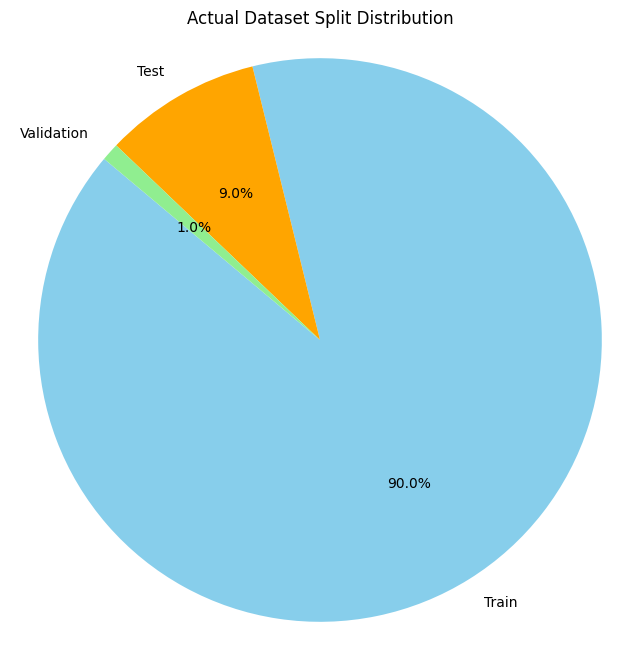

In [14]:
def count_images_in_split(split_folder):
    split_path = os.path.join(output_folder, split_folder)
    total_count = 0
    for category in os.listdir(split_path):
        category_path = os.path.join(split_path, category)
        if os.path.isdir(category_path):
            total_count += len([
                f for f in os.listdir(category_path)
                if os.path.isfile(os.path.join(category_path, f))
            ])
    return total_count

train_count = count_images_in_split('train')
test_count = count_images_in_split('test')
val_count = count_images_in_split('val')

sizes = [train_count, test_count, val_count]
labels = ['Train', 'Test', 'Validation']
colors = ['skyblue', 'orange', 'lightgreen']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Actual Dataset Split Distribution')
plt.axis('equal')
plt.show()


In [15]:
train_dir = os.path.join(output_folder, 'train')
test_dir  = os.path.join(output_folder, 'test')
val_dir   = os.path.join(output_folder, 'val')

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Loading data using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
)


test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,

)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False

)

Found 1587 images belonging to 3 classes.
Found 159 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


In [ ]:
class_counts = {}
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        class_counts[category] = len(os.listdir(category_path))

print("Number of images per category in train:")
print(class_counts)

Number of images per category in train:
{'c2': 512, 'c1': 730, 'c3': 345}


## Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = list(class_counts.keys())
counts = np.array([class_counts[c] for c in classes])


class_ints = [int(c[1]) for c in classes]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_ints),
    y=np.array([int(c[1]) for c, count in class_counts.items() for _ in range(count)])
)

class_weights_dict = dict(zip(class_ints, class_weights))

print("Class weights based on train data counts:")
print(class_weights_dict)


Class weights based on train data counts:
{2: np.float64(1.033203125), 1: np.float64(0.7246575342465753), 3: np.float64(1.5333333333333334)}


#### ***Insights***
Class 1 (weight ~0.7247)
This class has the lowest weight because it has the most images in your training set.
Weight < 1 means this class is over-represented compared to others.

Class 2 (weight ~1.0332)
This class has a weight close to 1, indicating it's roughly balanced compared to the average class size.

Class 3 (weight ~1.5333)
This class has the highest weight, meaning it has the fewest images and is under-represented.

Weight > 1 means this class is under-represented and the model needs to focus more on it.

## Model Building

## CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,311,779 (73.67 MB)

 Trainable params: 19,310,627 (73.66 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1,
    class_weight=class_weights_dict,
)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4450 - loss: 35.8627 - val_accuracy: 0.3333 - val_loss: 5.9955
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5163 - loss: 1.4226 - val_accuracy: 0.3333 - val_loss: 4.0873
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5223 - loss: 0.8616 - val_accuracy: 0.2222 - val_loss: 1.7221
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5096 - loss: 0.8652 - val_accuracy: 0.2222 - val_loss: 5.5905
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5224 - loss: 0.7633 - val_accuracy: 0.3333 - val_loss: 2.3818
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5697 - loss: 0.7645 - val_accuracy: 0.3333 - val_loss: 2.0466
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6022 - loss: 0.7304 - val_accuracy: 0.2222 - val_loss: 2.7947
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5505 - loss: 0.7560 - val_accuracy: 0.2778 - val_loss

Training Accuracy: 0.6093
Validation Accuracy: 0.7222
Training Loss: 0.6718
Validation Loss: 0.5864


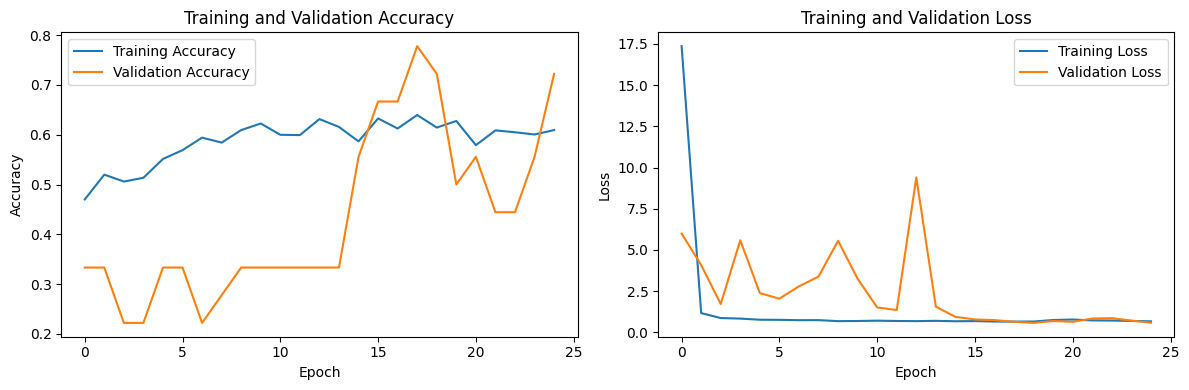

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Training Accuracy: {accuracy[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")
epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("Retinapathy_cnn_model.h5")
model_cnn= load_model("Retinapathy_cnn_model.h5")


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8838 - loss: 0.4263
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step
Test Loss: 0.5799
Test Accuracy : 0.7296
Accuracy: 0.7296
F1 Score: 0.6440


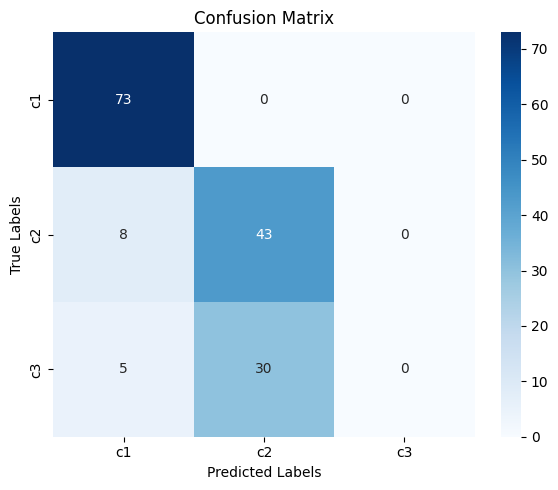


Classification Report:

              precision    recall  f1-score   support

          c1       0.85      1.00      0.92        73
          c2       0.59      0.84      0.69        51
          c3       0.00      0.00      0.00        35

    accuracy                           0.73       159
   macro avg       0.48      0.61      0.54       159
weighted avg       0.58      0.73      0.64       159



In [ ]:
test_loss, test_accuracy= model_cnn.evaluate(test_generator, verbose=1)

pred_probs = model_cnn.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')


print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


## Transfer Learning
**Transfer Learning** is a deep learning technique where a pre-trained model (trained on a large dataset like ImageNet) is adapted to a new but related task.

Instead of training from scratch, we reuse learned features, fine-tune some layers, and train only the classifier, saving time and improving accuracy, especially for small datasets

## DenseNet 121

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False
model_dense121 = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    BatchNormalization(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    BatchNormalization(),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.2),

    Dense(32, activation="relu"),

    Dense(3, activation="softmax")
])

# Optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

model_dense121.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model_dense121.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,348,355 (28.03 MB)

 Trainable params: 6,457,475 (24.63 MB)

 Non-trainable params: 890,880 (3.40 MB)

In [ ]:
# Training the model
history = model_dense121.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 506s 15s/step - accuracy: 0.4532 - loss: 1.5956 - precision: 0.4935 - recall: 0.3143 - val_accuracy: 0.5000 - val_loss: 1.5942 - val_precision: 0.7000 - val_recall: 0.3889
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5749 - loss: 1.3566 - precision: 0.7153 - recall: 0.4277 - val_accuracy: 0.5000 - val_loss: 1.5159 - val_precision: 0.6667 - val_recall: 0.4444
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6311 - loss: 1.2492 - precision: 0.7652 - recall: 0.4632 - val_accuracy: 0.5556 - val_loss: 1.3985 - val_precision: 0.7273 - val_recall: 0.4444
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6893 - loss: 1.1627 - precision: 0.7847 - recall: 0.5285 - val_accuracy: 0.6667 - val_loss: 1.2393 - val_precision: 0.8000 - val_recall: 0.4444
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6848 - loss: 1.1206 - precision: 0.7648 - recall: 0.5797 - val_accuracy: 0.7778 - val_loss: 1.1165 - v

Training Accuracy: 0.9231
Validation Accuracy: 0.8889
Training Loss: 0.7425
Validation Loss: 0.7836


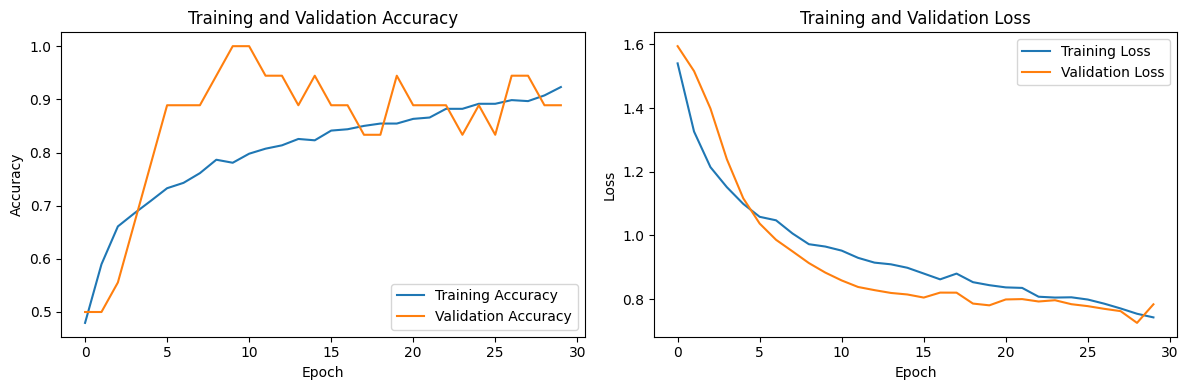

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(f"Training Accuracy: {accuracy[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")

# Plotting accuracy and loss
epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_dense121.save("model_dense121.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.9407 - loss: 0.7026 - precision: 0.9407 - recall: 0.9407
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Test Loss: 0.8364
Test Accuracy: 0.8742
Accuracy: 0.8742
F1 Score: 0.8728


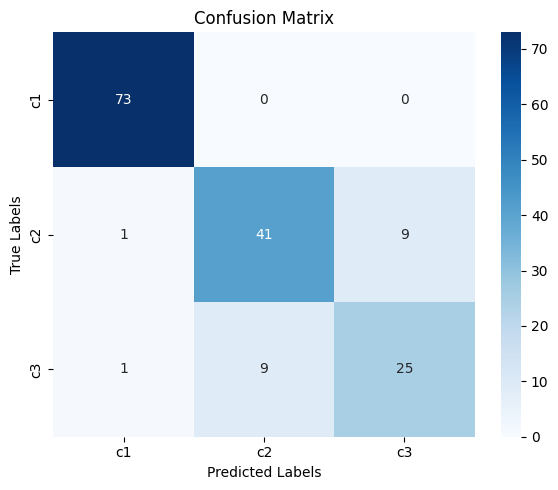


Classification Report:

              precision    recall  f1-score   support

          c1       0.97      1.00      0.99        73
          c2       0.82      0.80      0.81        51
          c3       0.74      0.71      0.72        35

    accuracy                           0.87       159
   macro avg       0.84      0.84      0.84       159
weighted avg       0.87      0.87      0.87       159



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model_dense121.evaluate(test_generator, verbose=1)
preds_121 = model_dense121.predict(test_generator)
y_pred = np.argmax(preds_121, axis=1)
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')


print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

#  Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


# **DenseNet201**

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

# Build the full model
model_dense201 = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    BatchNormalization(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    BatchNormalization(),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.2),

    Dense(32, activation="relu"),

    Dense(3, activation="softmax")
])

# Optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Compile the model
model_dense201.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)
model_dense201.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,865,795 (71.97 MB)

 Trainable params: 17,827,715 (68.01 MB)

 Non-trainable params: 1,038,080 (3.96 MB)

In [ ]:
# Training the model
history = model_dense201.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 673s 14s/step - accuracy: 0.3802 - loss: 1.7182 - precision: 0.4244 - recall: 0.2401 - val_accuracy: 0.4444 - val_loss: 1.5991 - val_precision: 0.5333 - val_recall: 0.4444
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6226 - loss: 1.3204 - precision: 0.7264 - recall: 0.4835 - val_accuracy: 0.4444 - val_loss: 1.5018 - val_precision: 0.6667 - val_recall: 0.4444
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6332 - loss: 1.2776 - precision: 0.7158 - recall: 0.5159 - val_accuracy: 0.5556 - val_loss: 1.3057 - val_precision: 0.8000 - val_recall: 0.4444
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6784 - loss: 1.1351 - precision: 0.7494 - recall: 0.5887 - val_accuracy: 0.7778 - val_loss: 1.1866 - val_precision: 0.8889 - val_recall: 0.4444
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7467 - loss: 1.0765 - precision: 0.7819 - recall: 0.6740 - val_accuracy: 0.8333 - val_loss: 1.0993 - v

Training Accuracy: 0.9445
Validation Accuracy: 0.9444
Training Loss: 0.7286
Validation Loss: 0.8300


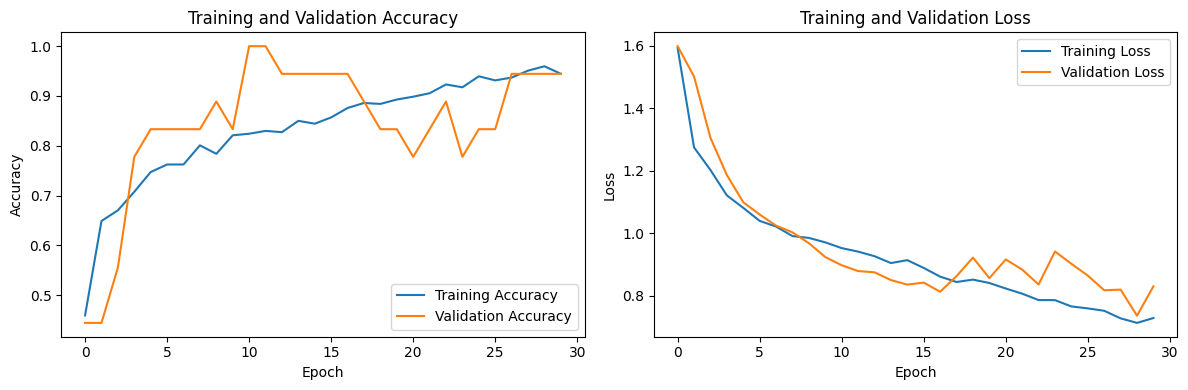

In [ ]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(f"Training Accuracy: {accuracy[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")


epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9446 - loss: 0.7546 - precision: 0.9465 - recall: 0.9446
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step
Test Loss: 0.9522
Test Accuracy: 0.8742
Accuracy: 0.8742
F1 Score: 0.8700


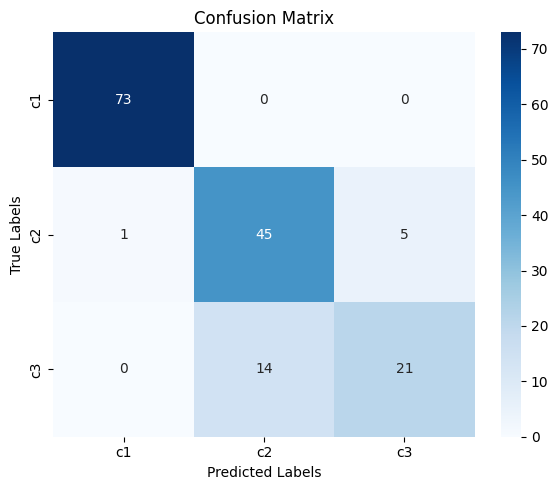


Classification Report:

              precision    recall  f1-score   support

          c1       0.99      1.00      0.99        73
          c2       0.76      0.88      0.82        51
          c3       0.81      0.60      0.69        35

    accuracy                           0.87       159
   macro avg       0.85      0.83      0.83       159
weighted avg       0.88      0.87      0.87       159



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model_dense201.evaluate(test_generator, verbose=1)
#  Predict class probabilities
preds_201 = model_dense201.predict(test_generator)
y_pred = np.argmax(preds_201, axis=1)
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

#  Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [ ]:
model_dense201.save("model_dense201.h5")


## MobileNet V2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)


model_mobilenetv2 = Model(inputs=base_model.input, outputs=predictions)
model_mobilenetv2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model_mobilenetv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Training the model
history = model_mobilenetv2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.3286 - loss: 1.5768 - precision: 0.3348 - recall: 0.2885 - val_accuracy: 0.4444 - val_loss: 1.0388 - val_precision: 0.5333 - val_recall: 0.4444
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4793 - loss: 1.1262 - precision: 0.4944 - recall: 0.4164 - val_accuracy: 0.6111 - val_loss: 0.8332 - val_precision: 0.6154 - val_recall: 0.4444
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5489 - loss: 0.9495 - precision: 0.5780 - recall: 0.4971 - val_accuracy: 0.6667 - val_loss: 0.6908 - val_precision: 0.7500 - val_recall: 0.6667
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5572 - loss: 0.8614 - precision: 0.5954 - recall: 0.5027 - val_accuracy: 0.7778 - val_loss: 0.6809 - val_precision: 0.7333 - val_recall: 0.6111
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6166 - loss: 0.7927 - precision: 0.6623 - recall: 0.5742 - val_accuracy: 0.7778 - val_loss: 0.6331 - val

Training Accuracy: 0.7171
Validation Accuracy: 0.8333
Training Loss: 0.5303
Validation Loss: 0.4503


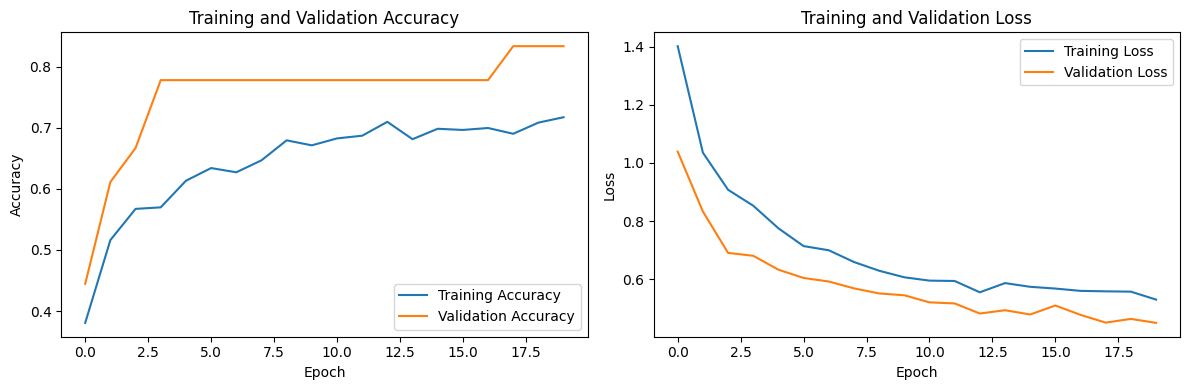

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Training Accuracy: {accuracy[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")
epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("model_mobilenetv2.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8687 - loss: 0.3440 - precision: 0.8763 - recall: 0.8376
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 851ms/step
Test Loss: 0.5781
Test Accuracy : 0.7610
Accuracy : 0.7610
F1 Score : 0.7465


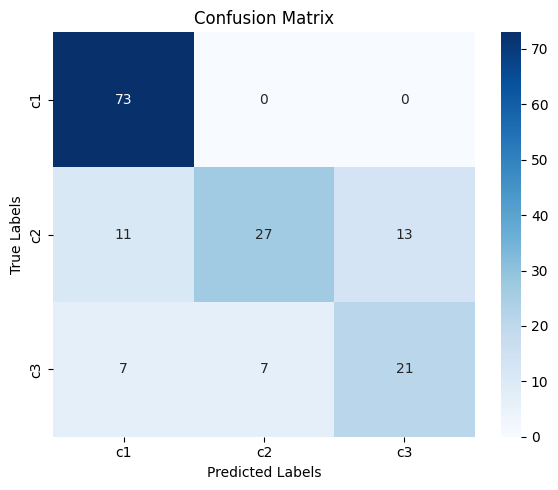


Classification Report:

              precision    recall  f1-score   support

          c1       0.80      1.00      0.89        73
          c2       0.79      0.53      0.64        51
          c3       0.62      0.60      0.61        35

    accuracy                           0.76       159
   macro avg       0.74      0.71      0.71       159
weighted avg       0.76      0.76      0.75       159



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model_mobilenetv2.evaluate(test_generator, verbose=1)
pred_probs = model_mobilenetv2.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


## Ensemble Model

In [ ]:
# Settin both models to non-trainable
model_dense121.trainable = False
model_dense201.trainable = False

input_layer = Input(shape=(224, 224, 3))

out1 = model_dense121(input_layer)
out2 = model_dense201(input_layer)

# Averagin their outputs
avg_output = Average()([out1, out2])


ensemble_model = Model(inputs=input_layer, outputs=avg_output)

ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



In [ ]:
history=ensemble_model.fit(train_generator,
                           validation_data=val_generator,
                           epochs=5,
                            batch_size=64,
                            verbose=1,
                            class_weight=class_weights_dict)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9726 - loss: 0.1066 - val_accuracy: 0.9444 - val_loss: 0.2054
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9691 - loss: 0.1028 - val_accuracy: 0.9444 - val_loss: 0.2054
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9787 - loss: 0.1109 - val_accuracy: 0.9444 - val_loss: 0.2054
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9734 - loss: 0.1050 - val_accuracy: 0.9444 - val_loss: 0.2054
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9720 - loss: 0.1067 - val_accuracy: 0.9444 - val_loss: 0.2054


Training Accuracy: 0.9742
Validation Accuracy: 0.9444
Training Loss: 0.1032
Validation Loss: 0.2054


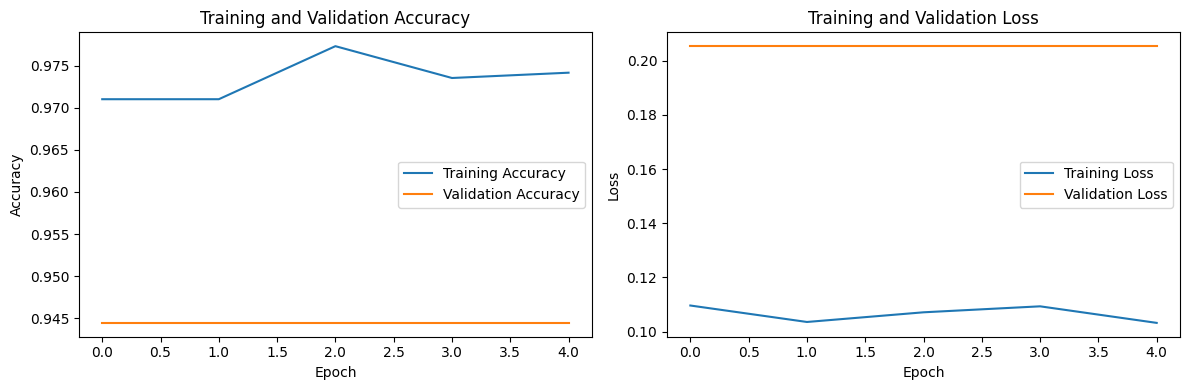

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(f"Training Accuracy: {accuracy[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")
epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9501 - loss: 0.1196


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step
Test Loss: 0.2510
Test Accuracy: 0.8868
Accuracy : 0.8868
F1 Score: 0.8840


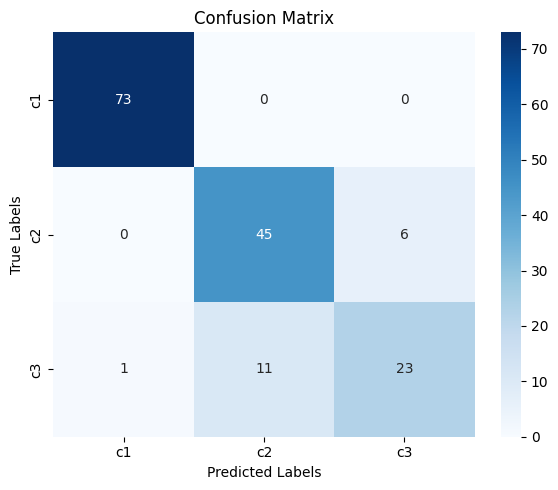


Classification Report:

              precision    recall  f1-score   support

          c1       0.99      1.00      0.99        73
          c2       0.80      0.88      0.84        51
          c3       0.79      0.66      0.72        35

    accuracy                           0.89       159
   macro avg       0.86      0.85      0.85       159
weighted avg       0.89      0.89      0.88       159



In [ ]:
test_loss, test_acc= ensemble_model.evaluate(test_generator, verbose=1)
pred_probs = ensemble_model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [ ]:
ensemble_model.save("ensemble_model.h5")

In [ ]:
weighted_avg = (0.4 * preds_121) + (0.6 * preds_201)
final_preds = np.argmax(weighted_avg, axis=1)
final_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 2, 2])

## Deploying the Model

In [ ]:
!pip install flask
!pip install pyngrok


In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import io

app = Flask(__name__)
model = load_model('ensemble_model.h5')
class_names = ['Mild', 'Moderate', 'Severe']

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image uploaded'}), 400

    file = request.files['image']
    img = Image.open(io.BytesIO(file.read())).convert('RGB')
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    confidence = float(np.max(predictions[0]))

    return jsonify({
        'prediction': class_names[class_idx],
        'confidence': round(confidence, 4)
    })




In [ ]:
!ngrok config add-authtoken 2xSFviCvG6zV19S48NLsKg2MZOI_DxiF6sAfSSstEShxsCUv


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(5001)
print(f" * ngrok tunnel URL: {public_url}")


 * ngrok tunnel URL: NgrokTunnel: "https://ed3d-34-82-204-205.ngrok-free.app" -> "http://localhost:5001"


In [ ]:
app.run(port=5001)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

def classify_via_api(image_path, api_url):
    try:

        img = Image.open(image_path).convert('RGB')
        plt.imshow(img)
        plt.axis('off')

        # Send image to API
        with open(image_path, 'rb') as f:
            files = {'image': f}
            response = requests.post(api_url, files=files)


        if response.status_code == 200:
            result = response.json()
            label = result.get('label', 'Unknown')
            confidence = result.get('confidence', 0)
            plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
        else:
            plt.title(f"API Error: {response.status_code}")
            print("Raw response:", response.text)

        plt.show()

    except Exception as e:
        print(f"Error: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step


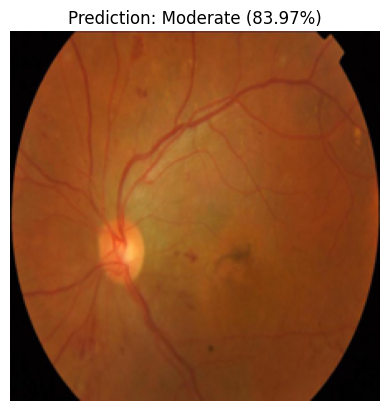

In [ ]:
api_url = "https://xxxxx.ngrok-free.app/predict"
image_path = "/content/drive/MyDrive/data/retinopathy/split_data/train/c2/o_c2t118363662.jpg"
classify_via_api(image_path, api_url)


## ***Insights***
 **Accuracy**

➤MobileNet V2 has the highest accuracy (0.8491), indicating it is the most reliable model among the four for this retinopathy classification task.


➤DenseNet121 follows with 0.8038 accuracy, showing strong performance but slightly lower than MobileNet V2.


➤ResNet50 V2 performs decently (0.7774) but is noticeably behind MobileNet V2.


➤CNN (Custom) has the lowest accuracy (0.2264), suggesting that a simple CNN architecture may not be capable of effectively learning complex features in retinal images.


**F1 Score**

➤MobileNet V2 also leads in F1 score (0.8465), showing consistent performance in both precision and recall for all classes.


➤DenseNet121 maintains a strong F1 score (0.7972), close to its accuracy, indicating balanced predictions.


➤ResNet50 V2 has a lower F1 score (0.7538), indicating some imbalance between precision and recall.


➤CNN (Custom) has the lowest F1 score (0.1536), further confirming its poor generalization ability.

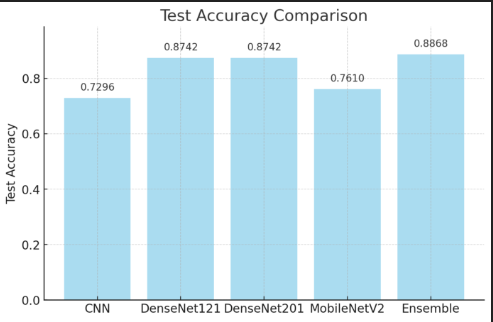

In [ ]:
from IPython.display import Image
Image('/content/retina acc .png')

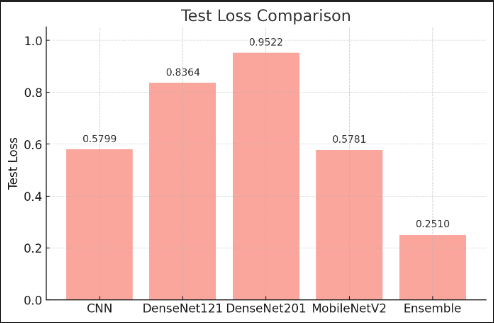

In [ ]:
from IPython.display import Image
Image('/content/retian loss.png')

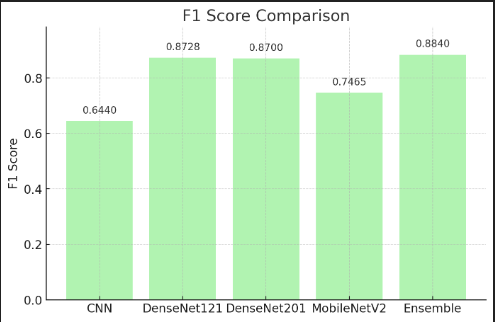

In [ ]:
from IPython.display import Image
Image('/content/retian f1 score.png')

## *Final Recommendation*
➤***Deploy the Ensemble Model (DenseNet121 + DenseNet201):***

It delivers the highest accuracy (0.8868) and F1 score (0.8840) with lowest test loss (0.2510), ensuring reliable and consistent performance in retinal disease detection.

➤***Ensure Real-time Inference:***

Optimize the ensemble model for deployment (using TensorFlow Lite or ONNX) to enable fast, real-time predictions suitable for clinical environments and telemedicine platforms.

➤***Integrate with Diagnostic Systems:***

Embed the model into hospital management systems or diagnostic apps to aid ophthalmologists and reduce diagnostic turnaround time.

➤***Support Clinical Decision-making:***

Use the model as a decision support tool to reduce human error and provide second opinions, especially in remote or under-resourced areas.

➤***Enable Scalable Screening:***

Roll out the solution in screening camps, primary health centers, and mobile eye-care units, addressing the shortage of specialists and improving early diagnosis at scale.

## *Challenges Faced*
***Limited Data Availability***

➤ High-quality labeled retinal images were scarce, making it difficult to train deep learning models effectively.

***Class Imbalance***

➤ Some disease classes had significantly fewer images, leading to biased learning and poor performance on minority classes.

***High Computational Requirements***

➤ Training deep models like DenseNet121 and DenseNet201 required powerful GPUs and longer processing time.